## The Following notebook is an implemenation of a GAN trained on the Fashion-MNIST dataset.

### Relevant Imports

In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import utils

# Setting to GPU 1.
if torch.cuda.is_available():
    torch.cuda.set_device(1)
    print("Cuda setup...")

Cuda setup...


### Const and Variables

In [2]:
BATCH_SIZE = 256
NUM_OF_WORKERS = 4

### Acquiring the dataset

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
)

# Training + test set loading.
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                            download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)


# Concat both sets
concated = torch.utils.data.ConcatDataset((trainset, testset))

datasetloader = torch.utils.data.DataLoader(concated, batch_size=BATCH_SIZE, 
                                            shuffle=True, num_workers=NUM_OF_WORKERS,
                                            drop_last = True)

print("Dataset ready")

Dataset ready


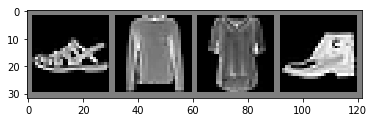

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show_prep(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1,2,0))
    
# get some random training images
dataiter = iter(datasetloader)
images, labels = dataiter.next()

# show the frist 8 images
plt.imshow(show_prep(torchvision.utils.make_grid(images[:4, :, :, :])))

# Discriminator

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 784
        n_out = 1

        first_conv = 64
        second_conv = 128
        third_layer = 100
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, first_conv, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # Size is 14
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(first_conv, second_conv, 1),
            nn.ReLU(),
            nn.MaxPool2d(2) # size is 7
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(second_conv * (7**2), 512), 
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Flattening x for fully connected layer.
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
#         x = self.fc3(x)
        x = self.out(x)
        return x
    
discriminator = Discriminator()
discriminator.cuda()
print("Discriminator Ready.")

Discriminator Ready.


# Generator

In [6]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 784

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.3)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.3)        
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x.view(x.shape[0], 1, 28, 28)
    
    def generate(self, size):
        latent = torch.Tensor(torch.randn(size, 100)).cuda()
        return self(latent)
    
generator = Generator()
generator.cuda()
print("Generator Ready.")

Generator Ready.


# Optimizers

In [7]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005)

criterion = torch.nn.BCELoss()

## Training Utils

In [8]:
def same_target(size, value):
    '''
    Tensor containing ones, with shape = size
    :param size: 
    :return: 
    '''
    data = torch.Tensor(torch.ones(size, 1))
    return data

def images_to_vectors(images):
    return images.view(images.size(0), images.shape[2] ** 2)

# Training

<IPython.core.display.Javascript object>


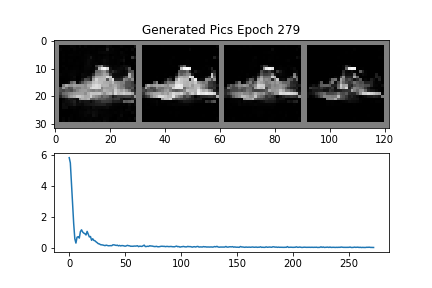

Started


/home/toky/anaconda3/envs/yoav/lib/python3.6/site-packages/ipykernel/__main__.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [ ]:
%%time
EPOCHS = 600

# TODO
# 1. Should print Discriminator and Generator error.
# 2. Save / Display generated images every x epochs.

# Setting up dynamic print and plot (everything will be re draw)
dm = utils.DynamicPlotter(True, 2)

import time
from IPython.display import clear_output

set_size = 256
real_labels = torch.Tensor(torch.ones(set_size, 1)).cuda()
fake_labels = torch.Tensor(torch.zeros(set_size, 1)).cuda()

im = []
for j in range(EPOCHS):
    im.append(generator.generate(4).cpu().detach())
    
    d_loss = []
    for i, batch in enumerate(datasetloader, 0):
#         clear_output(wait=True)
#         print("Working on the {} Epoch".format(j))
        batch_size = len(batch)
        
        # Ignoring the labels.
        real_set, _ = batch
        real_set = real_set.cuda()
                
        fake_set = generator.generate(set_size)
        fake_set = fake_set.cuda().detach()
        
        #-#-#-# Train Discriminator #-#-#-#
        
        d_optimizer.zero_grad()
        
        # Getting discriminator prediction
        real_prediction = discriminator(real_set)
        fake_prediction = discriminator(fake_set)
        
        loss_real = criterion(real_prediction, real_labels)
        loss_real.backward()
        
        loss_fake = criterion(fake_prediction, fake_labels)
        loss_fake.backward()
        
        d_loss.append(loss_real.data[0] + loss_fake.data[0])
        
        d_optimizer.step()
        
    for i in range(int(len(datasetloader) / 5.)):

        #-#-#-# Train Generator #-#-#-#
        
        g_optimizer.zero_grad()
        
        fake_set = generator.generate(set_size).cuda()
        fake_prediction = discriminator(fake_set)
        
        loss = criterion(fake_prediction, real_labels)
        loss.backward()
        
        g_optimizer.step()
        
    if (j+1) % 5 == 0 :
        gen_images = show_prep(torchvision.utils.make_grid(generator.generate(4).cpu().detach()))
        file_name = "fmnist_gan_progress/epoch_{}".format(j)
        dm.imshow(gen_images, "Generated Pics Epoch {}".format(j), file_name)
        dm.plot(d_loss)
        
        
print("Training Complete")

## Create a online plotting class

In [ ]:
img = show_prep(torchvision.utils.make_grid(generator.generate(16).cpu().detach()))
dm = utils.DynamicPlotter()
dm.imshow(img)

In [ ]:
 torch.Tensor(torch.randn(2, 5))

In [ ]:
len(datasetloader)

In [ ]:
int(1.3)